# Intro

This program generates dataset for neural network training and testing. The network aims to predict magnetic field at r = (0,0,0) based on the magnetic field values at 8 points with vectors r1 - r8. We assume that the magnetic field is created by an electromagnet from https://github.com/tretyakovmipt/TIRF-magnet-calibration . The magnet has three poles with parallel axes. Each pole creates a dipole field based on the applied voltage. To simulate non-linear behavior, we apply tanh (with appropriate scaling) to each pole's  input voltage.

# Setup

In [21]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

In [33]:
# Functions for the field calculation

def mag(x):
    """Calculates magnitude of vector x"""
    return np.sqrt(np.dot(x, x))


V_RANGE = 10 # Scaling factor for non-linear field. Global variable
NF = 15 # Non-linearity factor. Global variable.


def non_linear_dipole_field(r, r0, m, a):
    """
    Calculates magnetic field of a single dipole
    r - location of the field
    r0 - position of the dipole
    m - magnitude of the dipole. For each pole depends on applied voltage. Negative values correspond to the opposite orientation of  the dipole axis
    a - dipole axis"""
    M = V_RANGE * np.tanh(m / NF) * a  # Magnetic moment vector
    R = r - r0
    R = r - r0
    if np.dot(R, R) == 0:  #This one is to avoid singularities
        return np.array([0, 0, 0])
    return mu0 * (3 * R * (np.dot(M, R)) / (mag(R) ** 5) - M / (mag(R) ** 3))


def total_field(r, m_array: np.array, dipole_axis: np.array) -> np.array:
    """Calculates the total field at point r
    To simplify the data set generation later, the magnitudes of the three dipoles are placed in array m.
    B0 is the external field.
    dipole_axis is the dipole orientation (same for all three)"""
    B1 = non_linear_dipole_field(r, R1, m_array[0], dipole_axis)
    B2 = non_linear_dipole_field(r, R2, m_array[1], dipole_axis)
    B3 = non_linear_dipole_field(r, R3, m_array[2], dipole_axis)
    return B1 + B2 + B3

In [36]:
# Electromagnet parameters

mu0 = 10   # magnetic constant in arbitrary units (global vairable)

# Magnetic dipole position vectors
R1 = np.array([1, 0, 1])
R2 = np.array([-np.cos(np.pi / 3), np.sin(np.pi / 3), 1])
R3 = np.array([-np.cos(np.pi / 3), -np.sin(np.pi / 3), 1])

# Magnetic dipole orientation (same for all three)
A = np.array([0, 0, 1])  # It is a global variable

In [29]:
# The taget field location.
r0 = np.array([0., 0., 0.])

# Sensor locations
r1 = np.array([1, 1, 1])
r2 = np.array([-1, 1, 1])
r3 = np.array([-1, -1, 1])
r4 = np.array([1, -1, 1])
r5 = np.array([-1, -1, -1])
r6 = np.array([1, -1, -1])
r7 = np.array([1, 1, -1])
r8 = np.array([-1, 1, -1])

sensors_location = [r1, r2, r3, r4, r5, r6, r7, r8]

## Test that total_field() works properly
We look at B_vs_V curve for each field vector component vs V apllied to one pole at a time.

In [37]:
# Apply voltage to all poles one at a time

N1 = 128 # Number of training samples for each pole

V1 = np.concatenate((np.linspace(-V_RANGE , V_RANGE , N1), np.zeros(N1), np.zeros(N1)))
V2 = np.concatenate((np.zeros(N1), np.linspace(-V_RANGE , V_RANGE , N1), np.zeros(N1)))
V3 = np.concatenate((np.zeros(N1), np.zeros(N1), np.linspace(-V_RANGE , V_RANGE , N1)))

V = np.stack((V1, V2, V3), axis=1) # Stack vertically

# Calculate magnetic field

Bx, By, Bz, = [], [], []
for voltage in V:
    Bx.append(total_field(r0, voltage, A)[0])
    By.append(total_field(r0, voltage, A)[1])
    Bz.append(total_field(r0, voltage, A)[2])
Bx, By, Bz = np.array(Bx), np.array(By), np.array(Bz),

Text(0.5, 0, '$V_3$ (arb. u.)')

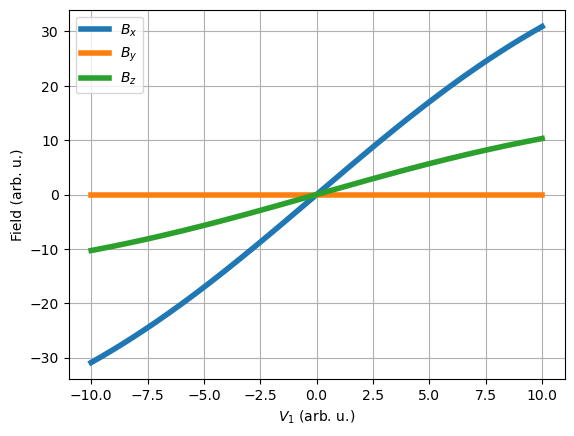

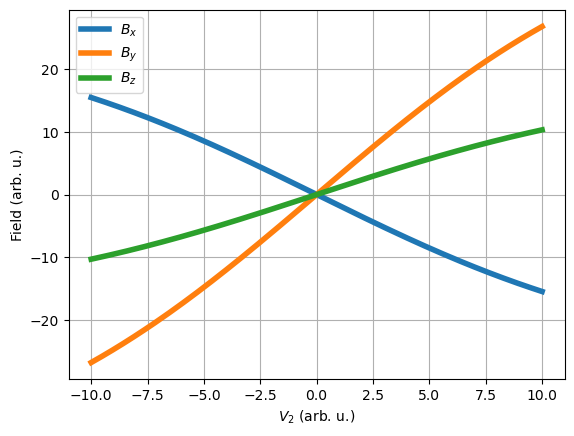

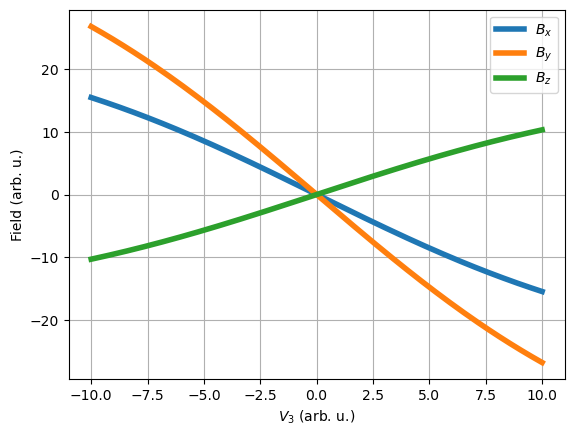

In [38]:
# Plot

def B_vs_V(x:np.array, y1:np.array, y2:np.array, y3:np.array):
    """plots y1, y2, and y3 vs x and returns the corresponding slopes"""
    index = x != 0 # Indexes for which v is non-zero
    x, y1, y2, y3 = x[index], y1[index], y2[index], y3[index] # Values for which v is non-zero

    # Plot
    fig, ax = plt.subplots()
    ax.plot(x, y1, label=r'$B_x$', linewidth=4.0)
    ax.plot(x, y2, label=r'$B_y$', linewidth=4.0)
    ax.plot(x, y3, label=r'$B_z$', linewidth=4.0)

    ax.set_ylabel('Field (arb. u.)' )
    #ax.set_xlim(0,1)
    ax.legend(loc=0)
    ax.grid()
    return ax

ax1 = B_vs_V(V1, Bx, By, Bz)
ax1.set_xlabel(r'$V_1$ (arb. u.)')

ax2 = B_vs_V(V2, Bx, By, Bz)
ax2.set_xlabel(r'$V_2$ (arb. u.)')

ax3 = B_vs_V(V3, Bx, By, Bz)
ax3.set_xlabel(r'$V_3$ (arb. u.)')

# Generate training datasets

In [ ]:

thetha = 2 * np.pi * np.linspace(0, 1, N)

B0 = []

Bx = []
By = []
Bz = []

for th in thetha:
    a = np.array([1, np.sin(th), np.cos(th)])
    B0.append(dipole(R0, r0, m, a, B_uniform))
    bx, by, bz = [], [], []
    for R in sensors:
        B = dipole(R, r0, m, a, B_uniform)
        bx.append(B[0])
        by.append(B[1])
        bz.append(B[2])
    Bx.append(bx)
    By.append(by)
    Bz.append(bz)

Bx = np.array(Bx)
By = np.array(By)
Bz = np.array(Bz)
B0 = np.array(B0)

B_train = np.stack((Bx, By, Bz), axis=2)